# EDA Assignment – 2 (Amazon Sales Data + Spotify Hip-Hop Data)  
**Submitter Name:** Aasif Majeed  
**Date:** 23 Mar 2024  

This notebook answers the EDA questions from the provided Assignment PDF using **two datasets**:

1. **Amazon Sales Data** (1K+ products)  
2. **Spotify Data: Popular Hip-Hop Artists and Tracks** (~500 entries)

Each question includes:
- the **question statement**
- **EDA steps / explanation**
- **Python code** + **plots** (Matplotlib / Pandas plotting)

**Dataset links (as provided):**
- Amazon: `https://drive.google.com/file/d/1yKlW0x5yyRQijmWbEg5YCsq4wqLl3_oB/view`
- Spotify: `https://drive.google.com/file/d/1JVgy2yXUOREkzRdCeWjep626uvvF94pP/view`


---
## 0) Setup

We will use:
- `pandas`, `numpy` for data processing
- `matplotlib` and `pandas.plotting` for visualization (no seaborn to keep dependencies minimal)

> **Note about Google Drive download**
If the download cell fails:
1) Install `gdown` with: `pip install gdown`  
2) OR manually download the dataset CSV(s) and place them in the same folder as this notebook.
---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import re
from collections import Counter

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)
np.set_printoptions(suppress=True)


---
## 1) Download / Load Datasets
We download both CSV files from Google Drive using their **file-id**.
---


In [2]:
def download_from_gdrive(file_id: str, output_path: str):
    """Download a Google Drive file to output_path using gdown (if installed)."""
    import os
    url = f"https://drive.google.com/uc?id={file_id}"
    if os.path.exists(output_path):
        print(f"Already exists: {output_path}")
        return output_path
    try:
        import gdown
    except ImportError as e:
        raise ImportError("gdown not installed. Run: pip install gdown OR download files manually.") from e

    gdown.download(url, output_path, quiet=False)
    return output_path


In [3]:
# ---- Amazon dataset ----
AMAZON_FILE_ID = "1yKlW0x5yyRQijmWbEg5YCsq4wqLl3_oB"
AMAZON_CSV = "amazon_sales_data.csv"

# ---- Spotify dataset ----
SPOTIFY_FILE_ID = "1JVgy2yXUOREkzRdCeWjep626uvvF94pP"
SPOTIFY_CSV = "spotify_hiphop_tracks.csv"

# Attempt downloads (safe to rerun)
try:
    download_from_gdrive(AMAZON_FILE_ID, AMAZON_CSV)
    download_from_gdrive(SPOTIFY_FILE_ID, SPOTIFY_CSV)
except Exception as e:
    print("Download note:", e)
    print("If needed, manually download both files and save as:")
    print(" -", AMAZON_CSV)
    print(" -", SPOTIFY_CSV)


Downloading...
From: https://drive.google.com/uc?id=1yKlW0x5yyRQijmWbEg5YCsq4wqLl3_oB
To: /Users/aasif/Downloads/data_sceice_pro_assignments /amazon_sales_data.csv
100%|██████████| 4.74M/4.74M [00:00<00:00, 20.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JVgy2yXUOREkzRdCeWjep626uvvF94pP
To: /Users/aasif/Downloads/data_sceice_pro_assignments /spotify_hiphop_tracks.csv
100%|██████████| 29.5k/29.5k [00:00<00:00, 5.56MB/s]


### Load datasets into DataFrames and normalize column names
We normalize to lowercase snake_case for reliable referencing.


In [4]:
amazon = pd.read_csv(AMAZON_CSV)
spotify = pd.read_csv(SPOTIFY_CSV)

amazon.columns = [c.strip().lower().replace(" ", "_") for c in amazon.columns]
spotify.columns = [c.strip().lower().replace(" ", "_") for c in spotify.columns]

print("Amazon shape:", amazon.shape)
print("Spotify shape:", spotify.shape)

amazon.head()


Amazon shape: (1465, 16)
Spotify shape: (440, 5)


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [5]:
spotify.head()


,artist,track_name,popularity,duration_(ms),track_id
0,Drake,Rich Baby Daddy (feat. Sexyy Red & SZA),92,319191,1yeB8MUNeLo9Ek1UEpsyz6
1,Drake,One Dance,91,173986,1zi7xx7UVEFkmKfv06H8x0
2,Drake,IDGAF (feat. Yeat),90,260111,2YSzYUF3jWqb9YP9VXmpjE
3,Drake,First Person Shooter (feat. J. Cole),88,247444,7aqfrAY2p9BUSiupwk3svU
4,Drake,Jimmy Cooks (feat. 21 Savage),88,218364,3F5CgOj3wFlRv51JsHbxhe


---
## 2) Data Quality Checks (Missing values + Duplicates)
We check both datasets for:
- missing values
- duplicate rows
Then we clean where needed.
---


In [6]:
def data_quality_report(df: pd.DataFrame, name: str):
    print("="*70)
    print(name)
    print("="*70)
    print("Shape:", df.shape)
    print("\nMissing values (top):")
    print(df.isna().sum().sort_values(ascending=False).head(15))
    dup = df.duplicated().sum()
    print("\nDuplicate rows:", dup)

data_quality_report(amazon, "AMAZON (raw)")
data_quality_report(spotify, "SPOTIFY (raw)")


AMAZON (raw)
Shape: (1465, 16)

Missing values (top):
rating_count           2
product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
dtype: int64

Duplicate rows: 0
SPOTIFY (raw)
Shape: (440, 5)

Missing values (top):
artist           0
track_name       0
popularity       0
duration_(ms)    0
track_id         0
dtype: int64

Duplicate rows: 27


In [7]:
# Remove exact duplicate rows (safe for EDA)
amazon = amazon.drop_duplicates().copy()
spotify = spotify.drop_duplicates().copy()

print("After removing duplicates:")
print("Amazon shape:", amazon.shape)
print("Spotify shape:", spotify.shape)


After removing duplicates:
Amazon shape: (1465, 16)
Spotify shape: (413, 5)


---
## 3) Cleaning & Feature Engineering

### Amazon dataset: numeric conversions
In many versions of this dataset:
- `discounted_price` / `actual_price` may contain currency symbols and commas (e.g., "₹1,299")
- `discount_percentage` may contain "%" sign
- `rating_count` may contain commas (e.g., "12,345")
- `rating` may be stored as text

We convert these columns to numeric so correlations and plots work correctly.
---


In [8]:
def to_numeric_money(s: pd.Series) -> pd.Series:
    # remove anything that's not digit or dot
    return pd.to_numeric(s.astype(str).str.replace(r"[^0-9.]", "", regex=True), errors="coerce")

def to_numeric_percent(s: pd.Series) -> pd.Series:
    # remove %, commas etc.
    return pd.to_numeric(s.astype(str).str.replace(r"[^0-9.]", "", regex=True), errors="coerce")

def to_numeric_int(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s.astype(str).str.replace(r"[^0-9]", "", regex=True), errors="coerce")

# Column names expected by assignment PDF (Amazon)
# product_id, product_name, category, discounted_price, actual_price, discount_percentage,
# rating, rating_count, about_product, user_id, user_name, review_id, review_title, review_content, img_link, product_link

for col in ["discounted_price", "actual_price"]:
    if col in amazon.columns:
        amazon[col] = to_numeric_money(amazon[col])

if "discount_percentage" in amazon.columns:
    amazon["discount_percentage"] = to_numeric_percent(amazon["discount_percentage"])

if "rating_count" in amazon.columns:
    amazon["rating_count"] = to_numeric_int(amazon["rating_count"])

if "rating" in amazon.columns:
    amazon["rating"] = pd.to_numeric(amazon["rating"], errors="coerce")

amazon[["discounted_price","actual_price","discount_percentage","rating","rating_count"]].head()


,discounted_price,actual_price,discount_percentage,rating,rating_count
0,399.0,1099.0,64,4.2,24269.0
1,199.0,349.0,43,4.0,43994.0
2,199.0,1899.0,90,3.9,7928.0
3,329.0,699.0,53,4.2,94363.0
4,154.0,399.0,61,4.2,16905.0


In [9]:
# Simple missing value handling for numeric columns (EDA-friendly)
for col in ["discounted_price","actual_price","discount_percentage","rating","rating_count"]:
    if col in amazon.columns:
        if amazon[col].isna().any():
            amazon[col] = amazon[col].fillna(amazon[col].median())

# For text columns, fill with empty string
for col in ["product_name","category","about_product","review_title","review_content"]:
    if col in amazon.columns:
        amazon[col] = amazon[col].fillna("")

data_quality_report(amazon, "AMAZON (cleaned)")


AMAZON (cleaned)
Shape: (1465, 16)

Missing values (top):
product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
dtype: int64

Duplicate rows: 0


### Spotify dataset: numeric conversions
Columns described:
- `artist`
- `track_name`
- `popularity`
- `duration_(ms)` or `duration_ms` (varies by file)

We detect likely columns and convert types.


In [10]:
# Detect columns (robust)
def first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found in df columns: {df.columns.tolist()}")

artist_col = first_existing(spotify, ["artist", "artists"])
track_col = first_existing(spotify, ["track_name", "track", "trackname", "song", "song_name"])
pop_col = first_existing(spotify, ["popularity"])
dur_col = None
for c in ["duration_ms", "duration_(ms)", "duration"]:
    if c in spotify.columns:
        dur_col = c
        break
if dur_col is None:
    raise KeyError("Could not find duration column in spotify dataset.")

spotify[pop_col] = pd.to_numeric(spotify[pop_col], errors="coerce")
spotify[dur_col] = pd.to_numeric(spotify[dur_col], errors="coerce")
spotify[artist_col] = spotify[artist_col].fillna("Unknown")
spotify[track_col] = spotify[track_col].fillna("Unknown")

# drop rows with missing essential numeric values
spotify = spotify.dropna(subset=[pop_col, dur_col]).copy()

data_quality_report(spotify, "SPOTIFY (cleaned)")
spotify.head()


SPOTIFY (cleaned)
Shape: (413, 5)

Missing values (top):
artist           0
track_name       0
popularity       0
duration_(ms)    0
track_id         0
dtype: int64

Duplicate rows: 0


,artist,track_name,popularity,duration_(ms),track_id
0,Drake,Rich Baby Daddy (feat. Sexyy Red & SZA),92,319191,1yeB8MUNeLo9Ek1UEpsyz6
1,Drake,One Dance,91,173986,1zi7xx7UVEFkmKfv06H8x0
2,Drake,IDGAF (feat. Yeat),90,260111,2YSzYUF3jWqb9YP9VXmpjE
3,Drake,First Person Shooter (feat. J. Cole),88,247444,7aqfrAY2p9BUSiupwk3svU
4,Drake,Jimmy Cooks (feat. 21 Savage),88,218364,3F5CgOj3wFlRv51JsHbxhe


---
# Part A — Amazon Sales Data (10 Questions)
Dataset described in the PDF includes product ratings, reviews, and price/discount information.  
We answer the listed questions (1–10).  
---


## Amazon Q1) What is the average rating for each product category?

### Approach
- Group by `category`
- Compute mean of `rating`
- Display top categories by average rating and also a bar chart for top 10.


In [11]:
avg_rating_by_cat = amazon.groupby("category")["rating"].mean().sort_values(ascending=False)
avg_rating_by_cat.head(15)


category
Computers&Accessories|Tablets                                                                    4.600000
Computers&Accessories|NetworkingDevices|NetworkAdapters|PowerLANAdapters                         4.500000
Electronics|Cameras&Photography|Accessories|Film                                                 4.500000
Electronics|HomeAudio|MediaStreamingDevices|StreamingClients                                     4.500000
OfficeProducts|OfficeElectronics|Calculators|Basic                                               4.500000
Home&Kitchen|Kitchen&HomeAppliances|Coffee,Tea&Espresso|CoffeePresses                            4.500000
Electronics|PowerAccessories|SurgeProtectors                                                     4.500000
HomeImprovement|Electrical|CordManagement                                                        4.500000
Home&Kitchen|CraftMaterials|PaintingMaterials                                                    4.500000
Computers&Accessories|Components|Memo

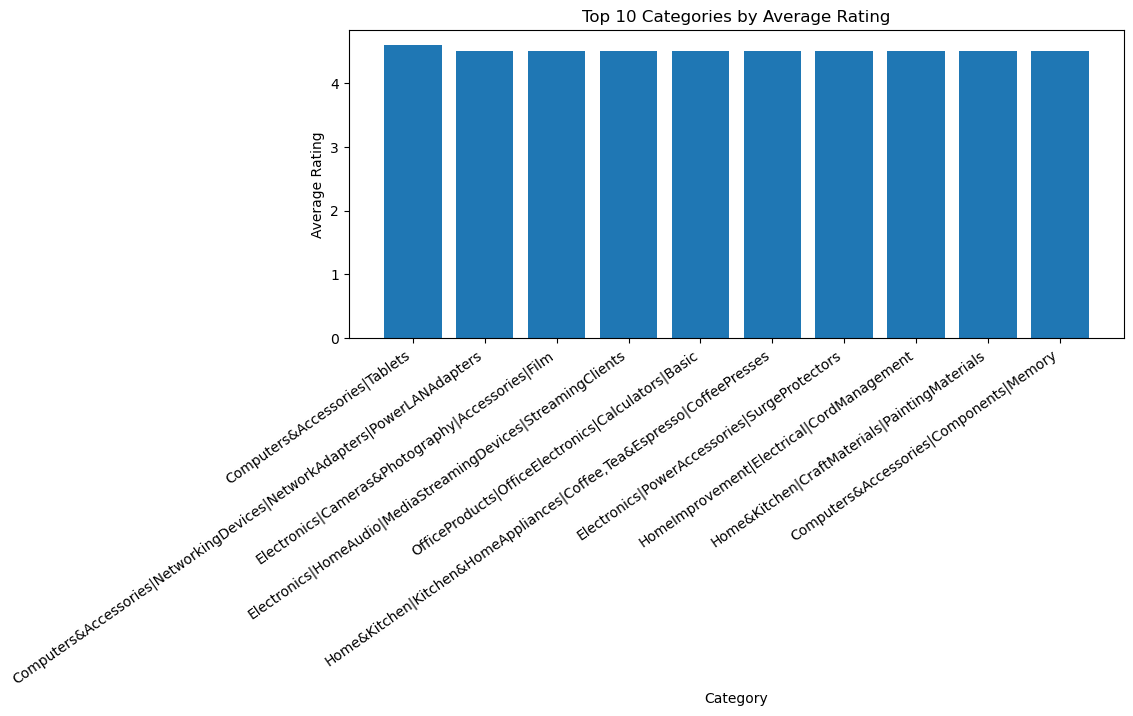

In [12]:
top10 = avg_rating_by_cat.head(10)

plt.figure(figsize=(10,4))
plt.bar(top10.index.astype(str), top10.values)
plt.title("Top 10 Categories by Average Rating")
plt.xlabel("Category")
plt.ylabel("Average Rating")
plt.xticks(rotation=35, ha="right")
plt.show()


## Amazon Q2) What are the top `rating_count` products by category?

### Approach
For each category, find the product(s) with maximum `rating_count`.
We show one top product per category.


In [13]:
# pick top product per category by rating_count
idx = amazon.groupby("category")["rating_count"].idxmax()
top_products_by_cat = amazon.loc[idx, ["category","product_name","rating_count","rating","discounted_price","actual_price"]].sort_values("category")
top_products_by_cat.head(20)


,category,product_name,rating_count,rating,discounted_price,actual_price
1157,Car&Motorbike|CarAccessories|InteriorAccessori...,Reffair AX30 [MAX] Portable Air Purifier for C...,1118.0,3.8,2339.0,4000.0
695,Computers&Accessories|Accessories&Peripherals|...,"rts [2 Pack] Mini USB C Type C Adapter Plug, T...",4426.0,4.3,294.0,4999.0
906,Computers&Accessories|Accessories&Peripherals|...,Hp Wired On Ear Headphones With Mic With 3.5 M...,7222.0,3.5,649.0,999.0
748,Computers&Accessories|Accessories&Peripherals|...,JBL Commercial CSLM20B Auxiliary Omnidirection...,14969.0,3.9,949.0,2000.0
844,Computers&Accessories|Accessories&Peripherals|...,Zebronics Zeb Wonderbar 10 USB Powered 2.0 Com...,7352.0,4.0,849.0,1499.0
794,Computers&Accessories|Accessories&Peripherals|...,Logitech C270 Digital HD Webcam with Widescree...,20398.0,4.3,1990.0,2595.0
602,Computers&Accessories|Accessories&Peripherals|...,LAPSTER Spiral Charger Spiral Charger Cable Pr...,8751.0,4.1,99.0,999.0
230,Computers&Accessories|Accessories&Peripherals|...,AmazonBasics 6 Feet DisplayPort to DisplayPort...,25177.0,4.4,499.0,1100.0
769,Computers&Accessories|Accessories&Peripherals|...,Quantum RJ45 Ethernet Patch Cable/LAN Router C...,8372.0,4.4,238.0,699.0
900,Computers&Accessories|Accessories&Peripherals|...,Lapster USB 3.0 sata Cable for 2.5 inch SSD an...,817.0,3.9,349.0,999.0


## Amazon Q3) What is the distribution of discounted prices vs. actual prices?

### Approach
- Plot histograms for `actual_price` and `discounted_price`
- Plot scatter to compare actual vs discounted


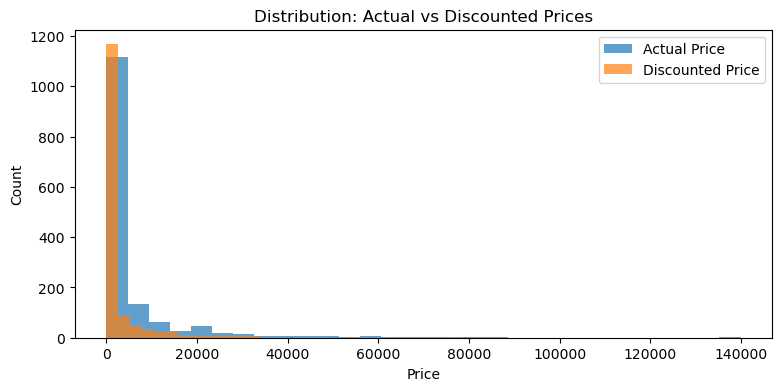

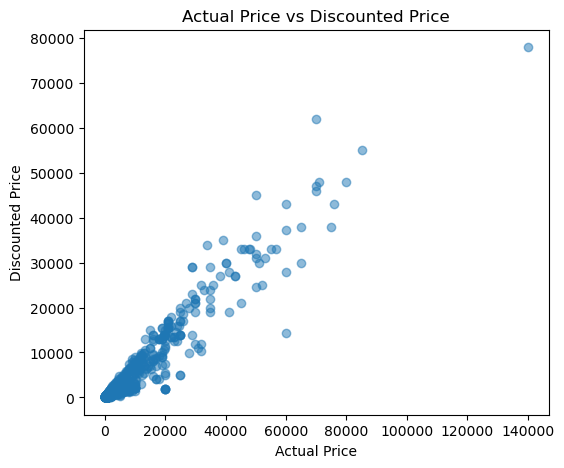

In [14]:
plt.figure(figsize=(9,4))
plt.hist(amazon["actual_price"], bins=30, alpha=0.7, label="Actual Price")
plt.hist(amazon["discounted_price"], bins=30, alpha=0.7, label="Discounted Price")
plt.title("Distribution: Actual vs Discounted Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(amazon["actual_price"], amazon["discounted_price"], alpha=0.5)
plt.title("Actual Price vs Discounted Price")
plt.xlabel("Actual Price")
plt.ylabel("Discounted Price")
plt.show()


## Amazon Q4) How does the average discount percentage vary across categories?

### Approach
- Group by category → mean(discount_percentage)
- Plot top 10 categories with highest average discount


In [15]:
avg_disc_by_cat = amazon.groupby("category")["discount_percentage"].mean().sort_values(ascending=False)
avg_disc_by_cat.head(15)


category
Electronics|Mobiles&Accessories|MobileAccessories|Décor|PhoneCharms                                              90.000000
Computers&Accessories|Accessories&Peripherals|Cables&Accessories|CableConnectionProtectors                       90.000000
Electronics|Headphones,Earbuds&Accessories|Earpads                                                               90.000000
Electronics|Headphones,Earbuds&Accessories|Adapters                                                              88.000000
Computers&Accessories|Accessories&Peripherals|Keyboards,Mice&InputDevices|Keyboard&MiceAccessories|DustCovers    87.500000
Electronics|Mobiles&Accessories|MobileAccessories|Mounts|Shower&WallMounts                                       82.000000
Computers&Accessories|Components|InternalHardDrives                                                              80.000000
Computers&Accessories|Accessories&Peripherals|Adapters|USBtoUSBAdapters                                          78.500000
Electro

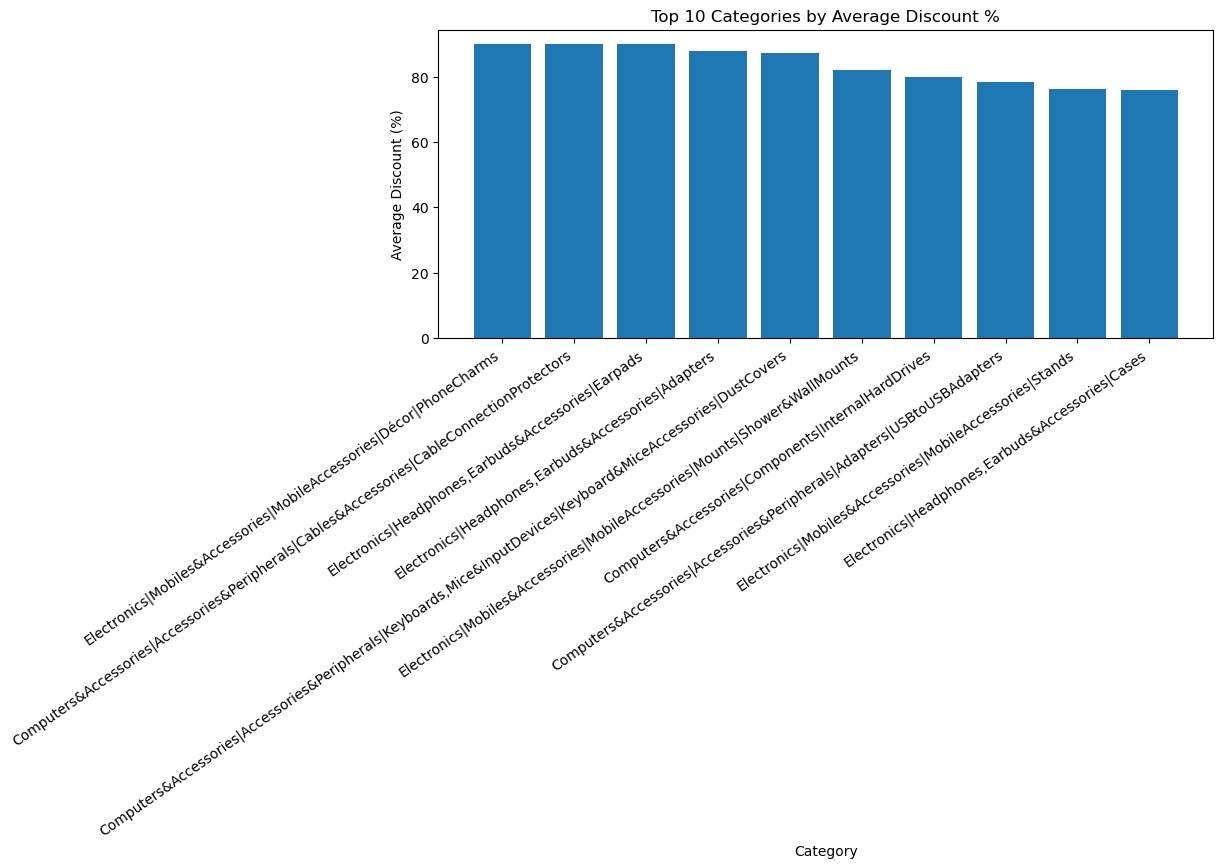

In [16]:
top10_disc = avg_disc_by_cat.head(10)

plt.figure(figsize=(10,4))
plt.bar(top10_disc.index.astype(str), top10_disc.values)
plt.title("Top 10 Categories by Average Discount %")
plt.xlabel("Category")
plt.ylabel("Average Discount (%)")
plt.xticks(rotation=35, ha="right")
plt.show()


## Amazon Q5) What are the most popular product names?

### Interpretation (EDA)
The dataset does not contain direct sales volume, so we interpret "popular" using **rating_count**:
- High `rating_count` → more users rated the product → commonly used as a popularity proxy.

### Approach
- Sort by `rating_count` descending
- Show top 10 product names


In [17]:
popular_products = amazon.sort_values("rating_count", ascending=False)[["product_name","category","rating","rating_count"]].head(10)
popular_products


,product_name,category,rating,rating_count
12,AmazonBasics Flexible Premium HDMI Cable (Blac...,"Electronics|HomeTheater,TV&Video|Accessories|C...",4.4,426973.0
65,"Amazon Basics High-Speed HDMI Cable, 6 Feet (2...","Electronics|HomeTheater,TV&Video|Accessories|C...",4.4,426973.0
47,"Amazon Basics High-Speed HDMI Cable, 6 Feet - ...","Electronics|HomeTheater,TV&Video|Accessories|C...",4.4,426973.0
684,AmazonBasics Flexible Premium HDMI Cable (Blac...,"Electronics|HomeTheater,TV&Video|Accessories|C...",4.4,426972.0
400,boAt Bassheads 100 in Ear Wired Earphones with...,"Electronics|Headphones,Earbuds&Accessories|Hea...",4.1,363713.0
352,boAt Bassheads 100 in Ear Wired Earphones with...,"Electronics|Headphones,Earbuds&Accessories|Hea...",4.1,363713.0
584,boAt BassHeads 100 in-Ear Wired Headphones wit...,"Electronics|Headphones,Earbuds&Accessories|Hea...",4.1,363711.0
370,"Redmi 9 Activ (Carbon Black, 4GB RAM, 64GB Sto...",Electronics|Mobiles&Accessories|Smartphones&Ba...,4.1,313836.0
371,"Redmi 9A Sport (Coral Green, 2GB RAM, 32GB Sto...",Electronics|Mobiles&Accessories|Smartphones&Ba...,4.1,313836.0
473,"Redmi 9A Sport (Carbon Black, 2GB RAM, 32GB St...",Electronics|Mobiles&Accessories|Smartphones&Ba...,4.1,313832.0


## Amazon Q6) What are the most popular product keywords?

### Approach
We extract keywords from `product_name` (and optionally `about_product`) by:
- lowercasing
- removing punctuation
- splitting into words
- removing very common stop-words

Then count word frequencies and show top keywords.


In [18]:
STOPWORDS = set([
    "the","and","or","for","with","to","of","in","on","a","an","is","it","this","that","from",
    "by","at","as","be","are","was","were","you","your","we","our","us","pack","set","new"
])

def tokenize(text: str):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    tokens = [t for t in text.split() if t and t not in STOPWORDS and len(t) > 2]
    return tokens

all_tokens = []
for t in amazon["product_name"].astype(str).tolist():
    all_tokens.extend(tokenize(t))

top_keywords = Counter(all_tokens).most_common(20)
top_keywords


[('black', 530),
 ('usb', 417),
 ('cable', 414),
 ('charging', 247),
 ('type', 243),
 ('fast', 212),
 ('smart', 175),
 ('white', 170),
 ('compatible', 146),
 ('data', 136),
 ('led', 129),
 ('pro', 125),
 ('wireless', 119),
 ('water', 114),
 ('remote', 109),
 ('heater', 108),
 ('bluetooth', 107),
 ('grey', 106),
 ('laptop', 105),
 ('battery', 97)]

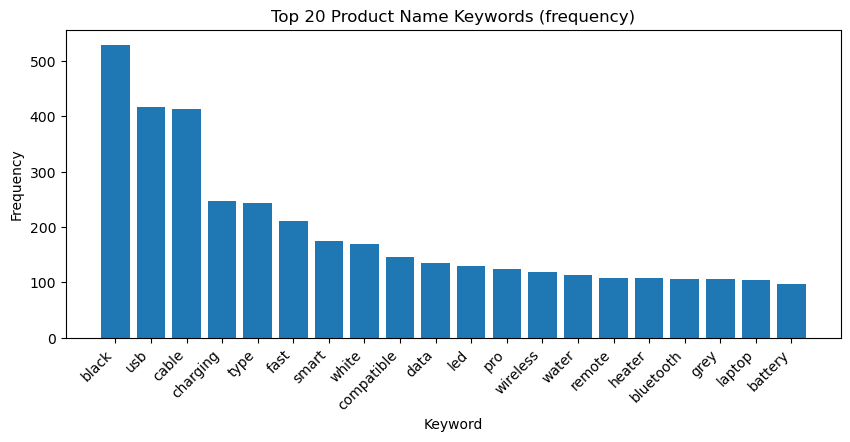

In [19]:
labels = [k for k,_ in top_keywords]
values = [v for _,v in top_keywords]

plt.figure(figsize=(10,4))
plt.bar(labels, values)
plt.title("Top 20 Product Name Keywords (frequency)")
plt.xlabel("Keyword")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.show()


## Amazon Q7) What are the most popular product reviews?

### Interpretation (EDA)
The dataset does not include a "helpful votes" metric, so we use **frequency** as a proxy:
- Most repeated `review_title`
- Most frequent words in `review_content`

This gives insight into common review themes.


In [20]:
# Top repeated review titles (if present)
if "review_title" in amazon.columns:
    top_titles = amazon["review_title"].astype(str).value_counts().head(10)
    display(top_titles)
else:
    print("review_title column not found.")


review_title
Worked on iPhone 7 and didn’t work on XR,Good one,Dull Physical Looks,Just Buy it,Go for it,About the product,Get charging cable at the price,Working well.                                                                                                                                     10
Satisfied,Charging is really fast,Value for money,Product review,Good quality,Good product,Good Product,As of now seems good                                                                                                                                                                     8
Phone, camera, heating - works for me, may not for all,Good Mobile,Good but not excellent under this budget,Worth the price at 9499,Ok type phone... but unable to make videocall within same service provider.,Phone review,Budget king,Battery backup is good                                  8
Good product,Good one,Nice,Really nice product,Very first time change,Good,Fine product but could be better,Very n

In [21]:
# Common words in review content
if "review_content" in amazon.columns:
    review_tokens = []
    for t in amazon["review_content"].astype(str).tolist():
        review_tokens.extend(tokenize(t))
    top_review_words = Counter(review_tokens).most_common(20)
    top_review_words
else:
    print("review_content column not found.")


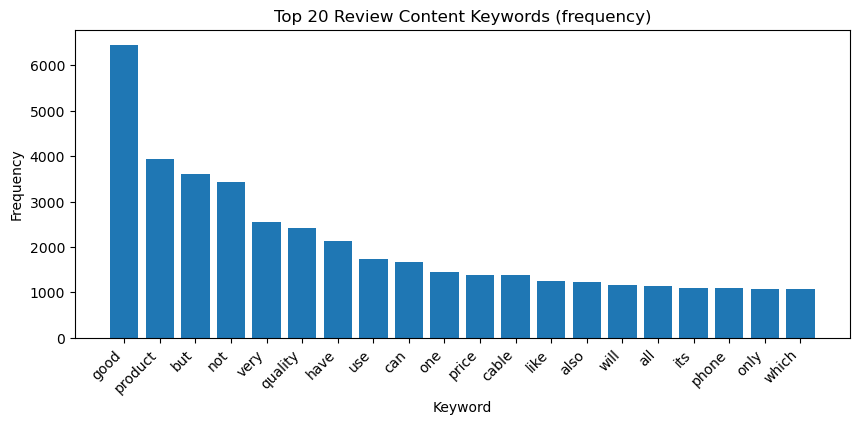

In [22]:
if "review_content" in amazon.columns:
    labels = [k for k,_ in top_review_words]
    values = [v for _,v in top_review_words]

    plt.figure(figsize=(10,4))
    plt.bar(labels, values)
    plt.title("Top 20 Review Content Keywords (frequency)")
    plt.xlabel("Keyword")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha="right")
    plt.show()


## Amazon Q8) What is the correlation between `discounted_price` and `rating`?

### Approach
- Compute Pearson correlation
- Make a scatter plot


Pearson correlation (discounted_price vs rating): 0.1203


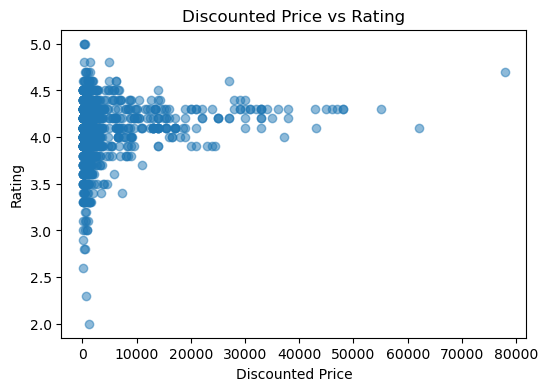

In [23]:
corr_price_rating = amazon["discounted_price"].corr(amazon["rating"])
print("Pearson correlation (discounted_price vs rating):", round(corr_price_rating, 4))

plt.figure(figsize=(6,4))
plt.scatter(amazon["discounted_price"], amazon["rating"], alpha=0.5)
plt.title("Discounted Price vs Rating")
plt.xlabel("Discounted Price")
plt.ylabel("Rating")
plt.show()


## Amazon Q9) What are the Top 5 categories based on the highest ratings?

### Approach
- Compute average rating per category
- Take top 5


In [24]:
top5_cats_rating = avg_rating_by_cat.head(5)
top5_cats_rating


category
Computers&Accessories|Tablets                                               4.6
Computers&Accessories|NetworkingDevices|NetworkAdapters|PowerLANAdapters    4.5
Electronics|Cameras&Photography|Accessories|Film                            4.5
Electronics|HomeAudio|MediaStreamingDevices|StreamingClients                4.5
OfficeProducts|OfficeElectronics|Calculators|Basic                          4.5
Name: rating, dtype: float64

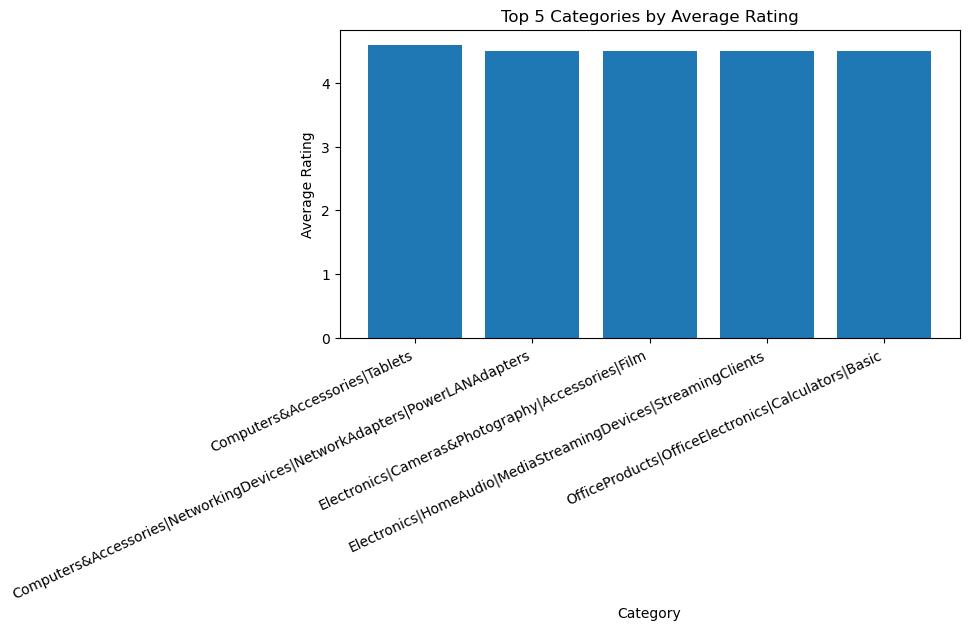

In [25]:
plt.figure(figsize=(8,4))
plt.bar(top5_cats_rating.index.astype(str), top5_cats_rating.values)
plt.title("Top 5 Categories by Average Rating")
plt.xlabel("Category")
plt.ylabel("Average Rating")
plt.xticks(rotation=25, ha="right")
plt.show()


## Amazon Q10) Identify potential areas for improvement or optimization based on the data analysis

### Data-driven ideas (examples)
Use insights such as:
- Categories with **high rating_count but low average rating** → investigate quality issues
- Categories with **large discounts** but not high ratings → discount not translating to satisfaction
- Review keyword themes → identify common complaints (battery, size, quality, delivery, etc.)

Below we compute a simple table to spot categories that might need improvement:
- High demand: high rating_count (sum)
- Low satisfaction: low average rating


In [26]:
cat_summary = amazon.groupby("category").agg(
    avg_rating=("rating","mean"),
    total_rating_count=("rating_count","sum"),
    avg_discount=("discount_percentage","mean"),
    avg_discounted_price=("discounted_price","mean")
).reset_index()

# Potential improvement candidates: high demand + low rating
candidates = cat_summary.sort_values(["total_rating_count","avg_rating"], ascending=[False, True]).head(15)
candidates


,category,avg_rating,total_rating_count,avg_discount,avg_discounted_price
76,"Electronics|Headphones,Earbuds&Accessories|Hea...",3.898077,4204939.0,58.269231,976.173077
10,Computers&Accessories|Accessories&Peripherals|...,4.151931,3558174.0,59.377682,360.723691
117,Electronics|Mobiles&Accessories|Smartphones&Ba...,4.100000,2493269.0,23.294118,15754.441176
89,"Electronics|HomeTheater,TV&Video|Accessories|C...",4.254167,1906054.0,59.791667,406.291667
119,Electronics|WearableTechnology|SmartWatches,4.025000,1644476.0,69.815789,2339.697368
58,Electronics|Accessories|MemoryCards|MicroSD,4.330769,1113592.0,58.846154,839.769231
42,Computers&Accessories|ExternalDevices&DataStor...,4.260000,774744.0,56.900000,668.600000
97,"Electronics|HomeTheater,TV&Video|Televisions|S...",4.209524,760279.0,38.285714,24840.190476
49,Computers&Accessories|NetworkingDevices|Networ...,4.094444,727113.0,49.111111,722.111111
103,Electronics|Mobiles&Accessories|MobileAccessor...,4.125000,688810.0,38.000000,1551.583333


### Short interpretation
- If a category appears here, it likely has **many ratings** (high exposure) but **lower average ratings**.
- Businesses can prioritize:
  - product quality checks
  - better description / expectation management
  - improved seller support / shipping and packaging
  - review mining to identify frequent issues


---
# Part B — Spotify Data: Popular Hip-Hop Artists and Tracks (10 Questions)
We answer questions 1–10 listed in the assignment PDF for this dataset.
---


## Spotify Q1) Load the dataframe and ensure data quality (missing values + duplicates). Handle them.

### What we did
- Loaded the CSV
- Standardized column names
- Removed duplicate rows
- Dropped rows missing key numeric values (popularity, duration)
- Filled missing text fields with `"Unknown"`

We print a final quality report below.


In [27]:
data_quality_report(spotify, "SPOTIFY (final cleaned)")
spotify.head()


SPOTIFY (final cleaned)
Shape: (413, 5)

Missing values (top):
artist           0
track_name       0
popularity       0
duration_(ms)    0
track_id         0
dtype: int64

Duplicate rows: 0


,artist,track_name,popularity,duration_(ms),track_id
0,Drake,Rich Baby Daddy (feat. Sexyy Red & SZA),92,319191,1yeB8MUNeLo9Ek1UEpsyz6
1,Drake,One Dance,91,173986,1zi7xx7UVEFkmKfv06H8x0
2,Drake,IDGAF (feat. Yeat),90,260111,2YSzYUF3jWqb9YP9VXmpjE
3,Drake,First Person Shooter (feat. J. Cole),88,247444,7aqfrAY2p9BUSiupwk3svU
4,Drake,Jimmy Cooks (feat. 21 Savage),88,218364,3F5CgOj3wFlRv51JsHbxhe


## Spotify Q2) What is the distribution of popularity among the tracks? (Histogram)

### Approach
- Plot histogram of `popularity`


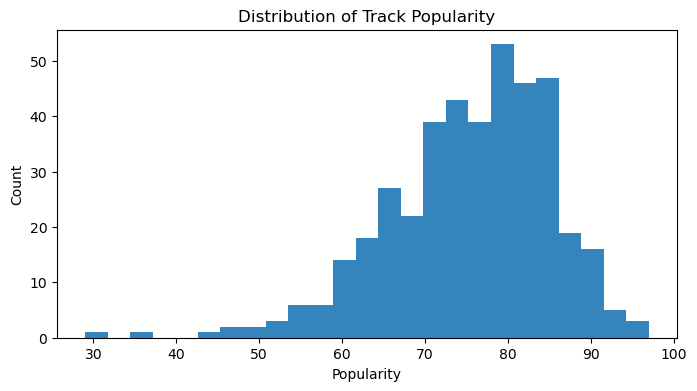

count    413.000000
mean      75.384988
std        9.789010
min       29.000000
25%       70.000000
50%       76.000000
75%       82.000000
max       97.000000
Name: popularity, dtype: float64

In [28]:
plt.figure(figsize=(8,4))
plt.hist(spotify[pop_col], bins=25, alpha=0.9)
plt.title("Distribution of Track Popularity")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

spotify[pop_col].describe()


## Spotify Q3) Relationship between popularity and duration (Scatter plot)

### Approach
- Scatter plot of `duration_ms` vs `popularity`
- Compute Pearson correlation


Pearson correlation (popularity vs duration): 0.039


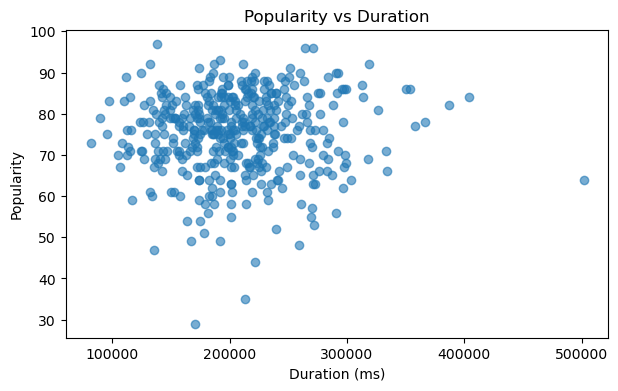

In [29]:
corr_pop_dur = spotify[pop_col].corr(spotify[dur_col])
print("Pearson correlation (popularity vs duration):", round(corr_pop_dur, 4))

plt.figure(figsize=(7,4))
plt.scatter(spotify[dur_col], spotify[pop_col], alpha=0.6)
plt.title("Popularity vs Duration")
plt.xlabel("Duration (ms)")
plt.ylabel("Popularity")
plt.show()


## Spotify Q4) Which artist has the highest number of tracks? Show count per artist

### Approach
- Count tracks per artist
- Identify max
- Plot top 15 as a bar chart (countplot equivalent)


In [30]:
artist_counts = spotify[artist_col].value_counts()
top_artist = artist_counts.idxmax()
print("Artist with highest number of tracks:", top_artist)
artist_counts.head(15)


Artist with highest number of tracks: Drake


artist
Drake             17
Eminem            11
Flo Rida          10
Ludacris          10
Timbaland         10
¥$                10
21 Savage         10
JAY-Z             10
Lil Nas X         10
Travis Scott       9
Lil Baby           9
Bizarrap           8
D-Block Europe     8
J. Cole            8
Kendrick Lamar     8
Name: count, dtype: int64

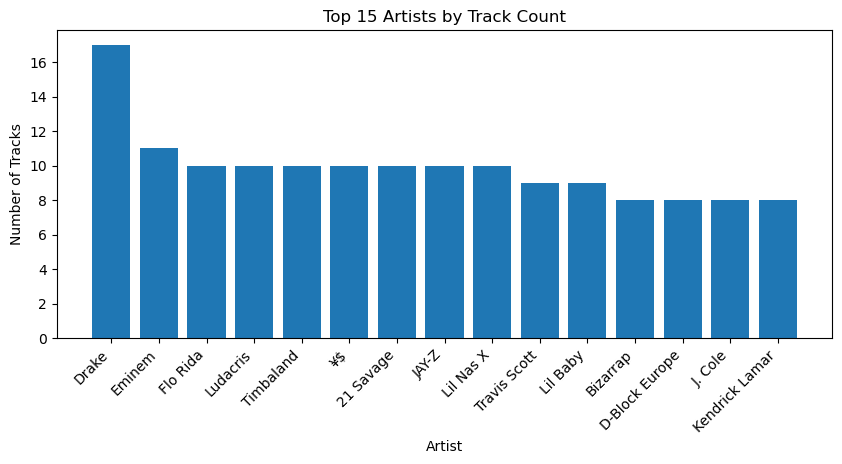

In [31]:
top15 = artist_counts.head(15)
plt.figure(figsize=(10,4))
plt.bar(top15.index.astype(str), top15.values)
plt.title("Top 15 Artists by Track Count")
plt.xlabel("Artist")
plt.ylabel("Number of Tracks")
plt.xticks(rotation=45, ha="right")
plt.show()


## Spotify Q5) What are the top 5 least popular tracks? (Artist + Track Name)

### Approach
- Sort by popularity ascending
- Show top 5


In [32]:
least5 = spotify.sort_values(pop_col, ascending=True)[[artist_col, track_col, pop_col, dur_col]].head(5)
least5


,artist,track_name,popularity,duration_(ms)
207,Pressa,Attachments (feat. Coi Leray),29,171000
231,Justin Bieber,Intentions,35,212853
413,French Montana,Splash Brothers,44,221863
225,Lil Baby,On Me - Remix,47,135444
407,Wyclef Jean,911 (feat. Mary J. Blige),48,259333


## Spotify Q6) Among the top 5 most popular artists, which artist has the highest average popularity?

### Interpretation
We define "most popular artists" using **average popularity** of their tracks.

### Approach
- Compute mean popularity per artist
- Take top 5 artists by mean popularity
- The top row has the highest average popularity


In [33]:
avg_pop_by_artist = spotify.groupby(artist_col)[pop_col].mean().sort_values(ascending=False)
top5_artists = avg_pop_by_artist.head(5)
top5_artists


artist
cassö           92.000000
Trueno          89.000000
David Guetta    87.000000
Travis Scott    86.555556
¥$              85.100000
Name: popularity, dtype: float64

In [34]:
best_artist = top5_artists.idxmax()
print("Artist with highest average popularity among top 5:", best_artist)


Artist with highest average popularity among top 5: cassö


## Spotify Q7) For the top 5 most popular artists, what are their most popular tracks?

### Approach
For each artist in the top-5 list:
- Filter rows for that artist
- Select the track with the maximum popularity


In [35]:
top5_artist_list = top5_artists.index.tolist()

most_pop_track_rows = []
for a in top5_artist_list:
    sub = spotify[spotify[artist_col] == a]
    best_row = sub.loc[sub[pop_col].idxmax()]
    most_pop_track_rows.append({
        "artist": a,
        "most_popular_track": best_row[track_col],
        "track_popularity": best_row[pop_col],
        "duration_ms": best_row[dur_col]
    })

pd.DataFrame(most_pop_track_rows)


,artist,most_popular_track,track_popularity,duration_ms
0,cassö,Prada,92,132359
1,Trueno,Mamichula - con Nicki Nicole,89,219201
2,David Guetta,Baby Don't Hurt Me,87,140017
3,Travis Scott,FE!N (feat. Playboi Carti),93,191700
4,¥$,CARNIVAL,96,264324


## Spotify Q8) Visualize relationships between multiple numerical variables (Pair plot)

### Approach (No seaborn)
We use `pandas.plotting.scatter_matrix` (pair-plot style) on numeric columns.


In [36]:
num_cols = spotify.select_dtypes(include=[np.number]).columns.tolist()
num_cols


['popularity', 'duration_(ms)']

<Figure size 1000x1000 with 0 Axes>

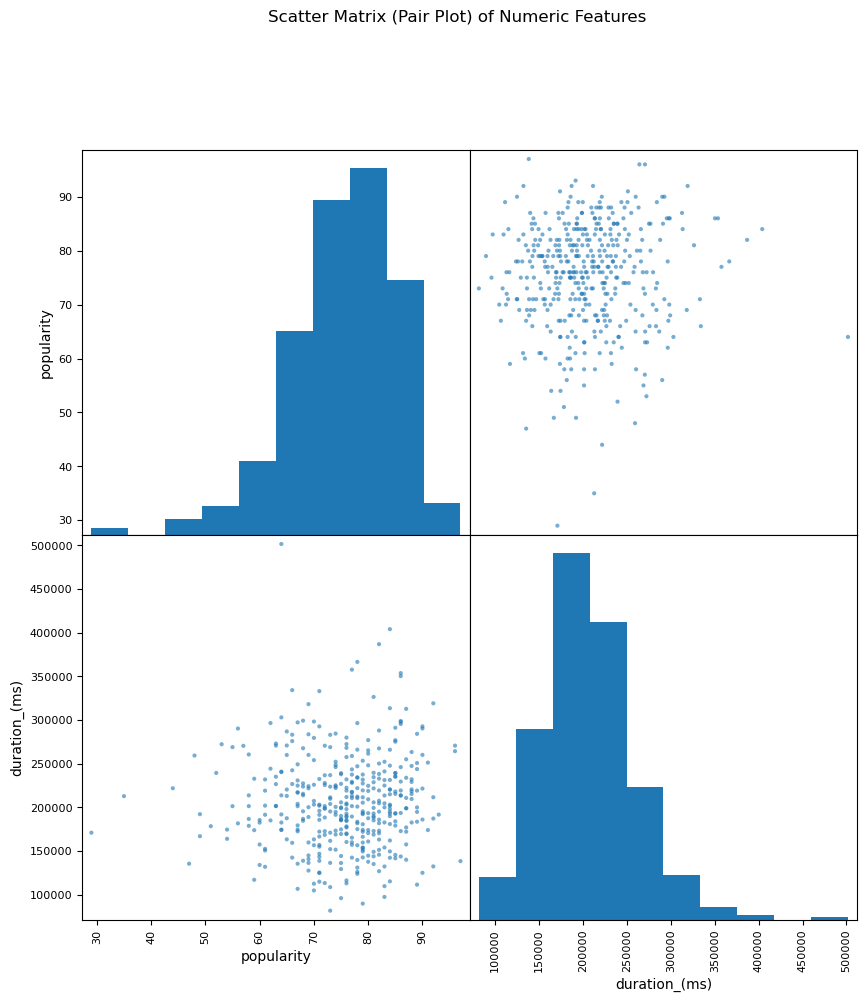

In [37]:
# Pair-plot style scatter matrix
plt.figure(figsize=(10,10))
scatter_matrix(spotify[num_cols], figsize=(10,10), alpha=0.6, diagonal="hist")
plt.suptitle("Scatter Matrix (Pair Plot) of Numeric Features", y=1.02)
plt.show()


## Spotify Q9) Does duration vary significantly across different artists? (Box/Violin)

### Approach
Because plotting all artists can be unreadable, we focus on **top 10 artists by track count**:
- Extract durations for each of these artists
- Use a **box plot** and a **violin plot** for visual comparison


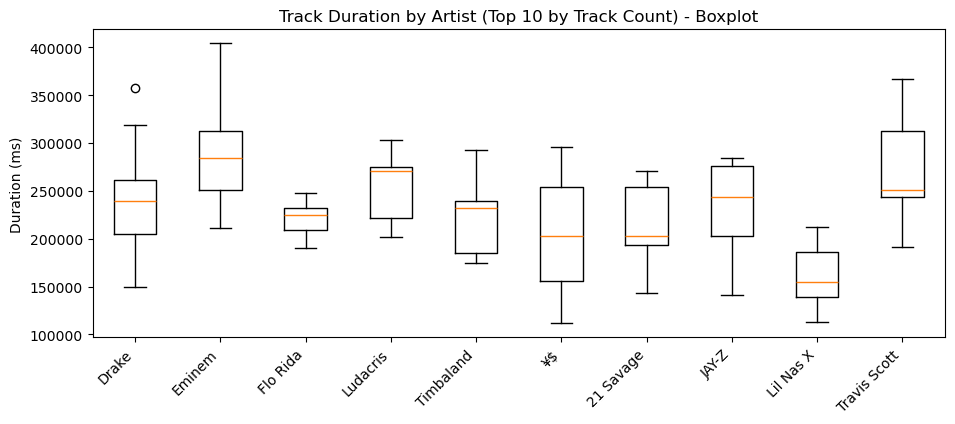

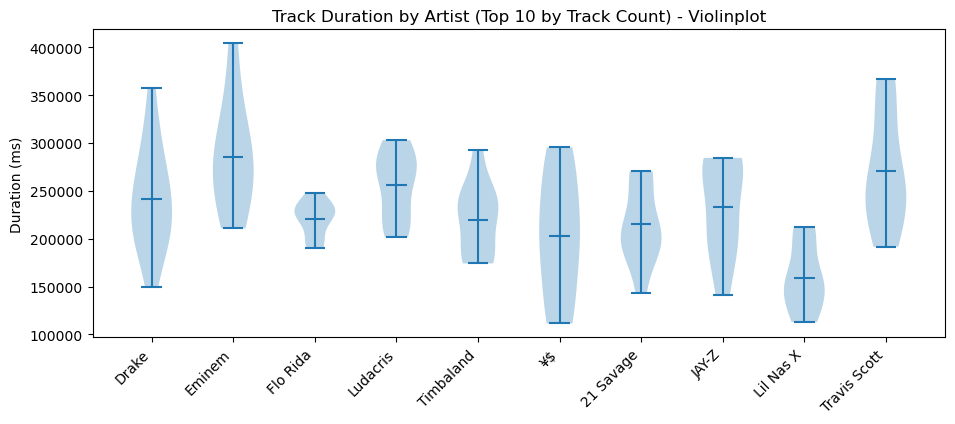

In [38]:
top10_artists_by_count = artist_counts.head(10).index.tolist()

dur_data = [spotify.loc[spotify[artist_col] == a, dur_col].values for a in top10_artists_by_count]

plt.figure(figsize=(11,4))
plt.boxplot(dur_data, labels=top10_artists_by_count)
plt.title("Track Duration by Artist (Top 10 by Track Count) - Boxplot")
plt.ylabel("Duration (ms)")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure(figsize=(11,4))
plt.violinplot(dur_data, showmeans=True, showextrema=True)
plt.title("Track Duration by Artist (Top 10 by Track Count) - Violinplot")
plt.ylabel("Duration (ms)")
plt.xticks(range(1, len(top10_artists_by_count)+1), top10_artists_by_count, rotation=45, ha="right")
plt.show()


## Spotify Q10) How does track popularity distribution vary for different artists? (Swarm/Violin)

### Approach (No seaborn)
A swarm plot is typically made with seaborn. Here we implement a **strip plot** with jitter using Matplotlib,
and also show a **violin plot** for the same top-10 artists.

- Violin plot shows distribution shape.
- Jittered scatter (strip plot) shows individual track points.


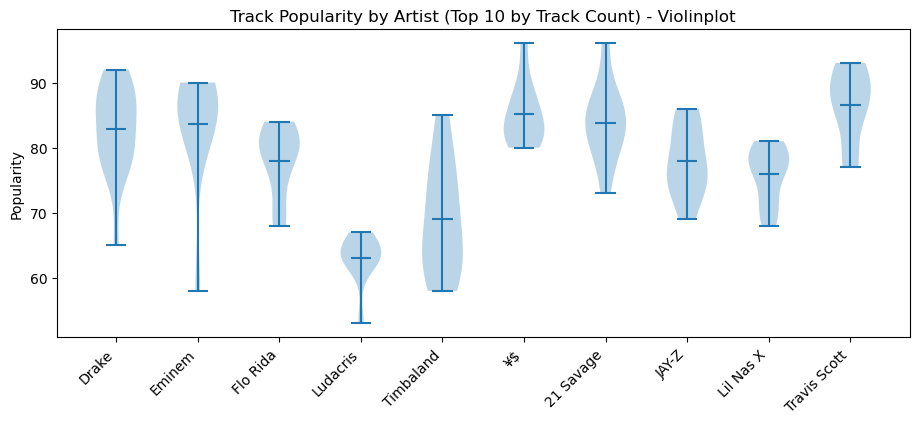

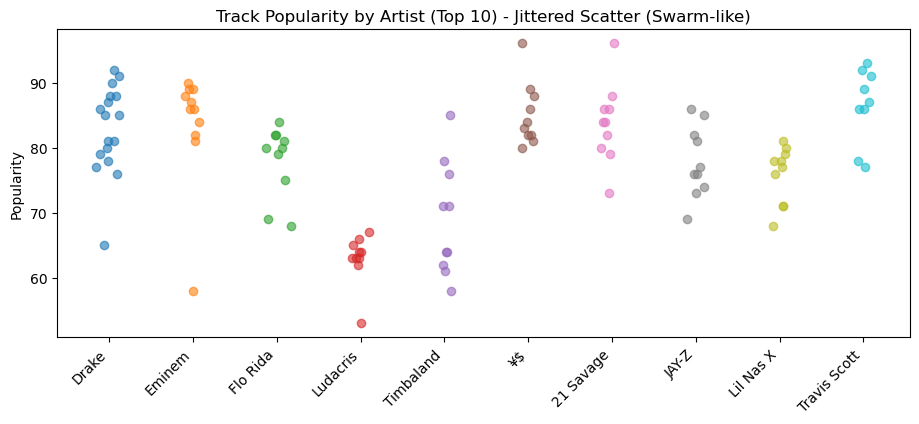

In [39]:
pop_data = [spotify.loc[spotify[artist_col] == a, pop_col].values for a in top10_artists_by_count]

# Violin plot
plt.figure(figsize=(11,4))
plt.violinplot(pop_data, showmeans=True, showextrema=True)
plt.title("Track Popularity by Artist (Top 10 by Track Count) - Violinplot")
plt.ylabel("Popularity")
plt.xticks(range(1, len(top10_artists_by_count)+1), top10_artists_by_count, rotation=45, ha="right")
plt.show()

# Strip plot with jitter
plt.figure(figsize=(11,4))
for i, a in enumerate(top10_artists_by_count, start=1):
    vals = spotify.loc[spotify[artist_col] == a, pop_col].values
    x = np.random.normal(loc=i, scale=0.06, size=len(vals))  # jitter around category index
    plt.scatter(x, vals, alpha=0.6)

plt.title("Track Popularity by Artist (Top 10) - Jittered Scatter (Swarm-like)")
plt.ylabel("Popularity")
plt.xticks(range(1, len(top10_artists_by_count)+1), top10_artists_by_count, rotation=45, ha="right")
plt.show()


---
## Final Summary
This notebook completed EDA for both datasets:
- **Amazon Sales Data:** average rating by category, top-rated-count products, price distributions, discount patterns, keyword/review mining, correlation analysis, and improvement insights.
- **Spotify Hip-Hop Data:** data quality, popularity distribution, popularity-duration relationship, artist/track ranking, most popular tracks per artist, scatter-matrix, duration and popularity comparisons across artists.

If you want, I can also export key tables (CSV) or save figures to disk for submission.
---
